In [137]:
from sentence_transformers import SentenceTransformer
import random
import librosa
import numpy as np
import pandas as pd
import ffmpeg as ff
import cv2
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.regression import MeanAbsolutePercentageError
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import transforms
from PIL import Image
import json    
from tqdm import tqdm
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error
from time import time

import warnings 
warnings.filterwarnings('ignore')

os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Препроцессинг

Для ускорения обучения все обучающие, валидационные и тестовые данные были предобработаны согласно пайплайну - получены мел-кепстральные коэффициенты для аудио, эмбеддинги транскрипций и кадров из видео.

In [113]:
class MultimodalTransformer:
    # Класс для осуществления препроцессинга данных
    def __init__(self, device, verbose=False, return_path=False):
        self.text_model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True).to(device)
        self.mtcnn = MTCNN(margin=20, keep_all=True, device=device)
        self.cv_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
        self.device = device
        self.verbose = verbose
        self.return_path = return_path


    def __call__(self, sample):
        path = sample['video_path']
        text = sample['transcription']
        
        # получение кадров из видео
        frames = self.get_frames(path)

        # получение мел-кепстральных коэффициентов из аудио
        mfcc = self.transform_audio(path)
        mfcc = torch.FloatTensor(mfcc)

        if 'labels' in sample.keys():
            if self.return_path:
                return (path, text, frames, mfcc, sample['labels'])
            return (text, frames, mfcc, sample['labels'])
        else:
            if self.return_path:
                return (path, text, frames, mfcc, )
            return (text, frames, mfcc, )

    def transform_texts(self, texts):
        # получение эмбеддингов транскрипций видео
        if self.verbose:
            print('Calculating text embeddings...')
        embeddings = self.text_model.encode(texts, task='classification', prompt_name='classification')
        return embeddings

    def get_frames(self, path):
        # получение кадров из видео
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
        random_indexes = sorted(random.sample(range(total_frames), 6))
        
        video_frames = []
        current_index = 0
        
        for i in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            if i == random_indexes[current_index]:
                video_frames.append(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (640, 360)))
                current_index += 1
                if current_index >= 6:
                    break

        cap.release()
        cv2.destroyAllWindows()

        return video_frames

    def detect_and_embed(self, batch_images):
        # детекция и эмбеддинг лиц на кадрах из видео
        if self.verbose:
            print('Detecting faces...')
        faces_list = self.mtcnn(batch_images)
        del batch_images
        
        all_faces = []
    
        for faces in faces_list:
            if faces is not None and len(faces) > 0:
                faces_resized = [torch.nn.functional.interpolate(faces[0].unsqueeze(0), size=(160, 160), mode='bilinear', align_corners=False).squeeze(0)]
                all_faces.extend(faces_resized)
            else:
                all_faces.extend([torch.zeros(3, 160, 160, dtype=torch.float32)])
        
        if all_faces:
            all_faces_tensor = torch.stack(all_faces).to(self.device)
            del all_faces

            if self.verbose:
                print('Embedding faces...')
            embeddings = self.cv_model(all_faces_tensor).cpu()
            del all_faces_tensor
            return embeddings
        else:
            return None

    def aggregate_embeddings(self, embeddings):
        # агрегирование эмбеддингов кадров
        if embeddings is not None and len(embeddings) > 0:
            return torch.mean(embeddings, axis=1)
        else:
            return None
    
    def transform_video(self, video_frames):
        # получение агрегированных эмбеддингов из кадров видео
        if len(video_frames[0].shape) == 4:
            tensor_data = torch.stack(video_frames, axis=1)
            tensor_data_ = tensor_data.reshape(tensor_data.shape[0]*tensor_data.shape[1], *tensor_data.shape[2:])
            embeddings = self.detect_and_embed(tensor_data_)
            del tensor_data_
            aggregated = self.aggregate_embeddings(embeddings.reshape(tensor_data.shape[0], tensor_data.shape[1], 512))
        else:
            tensor_data = torch.stack(video_frames, axis=0)
            embeddings = self.detect_and_embed(tensor_data)
            aggregated = self.aggregate_embeddings(embeddings.unsqueeze(0))
            
        del embeddings

        return aggregated

    def transform_audio(self, path):
        # получение мел-кепстральных коэффициентов из аудио
        inputfile = ff.input(path) # загружаем видео
        out = inputfile.output('-', format='f32le', acodec='pcm_f32le', ac=1, ar='44100', loglevel='quiet') # отделяем звук
        raw = out.run(capture_stdout=True)
        del inputfile, out
        raw_data = np.frombuffer(raw[0],np.float32)

        mfcc_data = librosa.feature.mfcc(y=raw_data, n_mfcc=16) # получаем MFCC из звуковой дорожки
        mfcc_data_standardized = (mfcc_data - np.mean(mfcc_data)) / np.std(mfcc_data) # стандартизация

        # truncating и padding
        if mfcc_data_standardized.shape[1] > 1319:
            processed = mfcc_data_standardized[:, :1319]
        else:
            n_pad_cols = 1319 - mfcc_data_standardized.shape[1]
            padding = np.zeros((16, n_pad_cols))

            processed = np.hstack((padding, mfcc_data_standardized))

        del mfcc_data, mfcc_data_standardized, raw_data

        return processed

In [4]:
class VideoTextDataset(Dataset):
    def __init__(self, video_folder, pkl_file, labels, transform=None, has_target=True):
        """
        Args:
            video_folder (str): Directory where video files are located.
            pkl_file (str): Path to the pickle file with video filenames and transcriptions.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.video_folder = video_folder
        self.transform = transform
        self.has_target = has_target
        
        with open(pkl_file, 'rb') as f:
            self.video_data = pickle.load(f, encoding='latin1')
            
        with open(labels, 'rb') as f:
            self.labels = pickle.load(f, encoding='latin1')
    
        
    def __len__(self):
        return len(self.video_data)

    def __getitem__(self, idx):
        video_filename = list(self.video_data.keys())[idx]
        transcription = self.video_data[video_filename]
        video_path = os.path.join(self.video_folder, video_filename)


        if self.has_target:
            labels_keys = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism', 'interview']
            l = torch.FloatTensor([self.labels[k][video_filename] for k in labels_keys])
    
            sample = {
                'video_path': video_path,
                'transcription': transcription,
                'labels': l
            }

        else:
            sample = {
                'video_path': video_path,
                'transcription': transcription,
            }
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [ ]:
transformer_preprocess = MultimodalTransformer(device=device, return_path=True)

In [6]:
video_folder_train = "./train_dataset/train/train_data/"
pkl_file_train = "./train_dataset/train/transcription/transcription_training.pkl"
labels_train = "./train_dataset/train/annotation/annotation_training.pkl"

train_preprocess_dataset = VideoTextDataset(video_folder_train, pkl_file_train, labels_train, transform=transformer_preprocess)
train_preprocess_loader = DataLoader(train_preprocess_dataset, batch_size=64, shuffle=False, num_workers=4)

video_folder_val = "./train_dataset/valid/validation/"
pkl_file_val = "./train_dataset/valid/transcription/transcription_validation.pkl"
labels_val = "./train_dataset/valid/annotation/annotation_validation.pkl"

val_preprocess_dataset = VideoTextDataset(video_folder_val, pkl_file_val, labels_val, transform=transformer_preprocess)
val_preprocess_loader = DataLoader(val_preprocess_dataset, batch_size=64, shuffle=False, num_workers=4)

In [5]:
def preprocess(dataloader, has_target=True):    
    embed_dict = dict()

    if has_target:
        for batch_idx, (paths, texts_raw, video_raw, audio_data, labels) in enumerate(tqdm(dataloader)):
            video_data = transformer_preprocess.transform_video(video_raw)
            text_data = transformer_preprocess.transform_texts(texts_raw)
    
            for i, path in enumerate(paths):
                embed_dict[path] = {
                    'text_embed': text_data[i].tolist(),
                    'video_embed': video_data[i].tolist(),
                    'audio_embed': audio_data[i].tolist(),
                    'labels': labels[i].tolist()
                }
    else:
        for batch_idx, (paths, texts_raw, video_raw, audio_data, ) in enumerate(tqdm(dataloader)):
            video_data = transformer_preprocess.transform_video(video_raw)
            text_data = transformer_preprocess.transform_texts(texts_raw)
    
            for i, path in enumerate(paths):
                embed_dict[path] = {
                    'text_embed': text_data[i].tolist(),
                    'video_embed': video_data[i].tolist(),
                    'audio_embed': audio_data[i].tolist(),
                }

    return embed_dict

In [8]:
#train_embed_dict = preprocess(train_preprocess_loader)

# Convert and write JSON object to file
#with open("train_embed_v2.json", "w") as outfile: 
#    json.dump(train_embed_dict, outfile)

100%|██████████| 94/94 [55:46<00:00, 35.60s/it]  


In [ ]:
#del train_embed_dict

In [9]:
#val_embed_dict = preprocess(val_preprocess_loader)

# Convert and write JSON object to file
#with open("val_embed_v2.json", "w") as outfile: 
#    json.dump(val_embed_dict, outfile)

100%|██████████| 32/32 [19:00<00:00, 35.64s/it]  


In [ ]:
#del val_embed_dict

# Архитектура модели

In [6]:
class MultimodalInterviewModel(nn.Module):
    def __init__(self, use_torch_clf=True):
        super(MultimodalInterviewModel, self).__init__()
        
        self.use_torch_clf = use_torch_clf
        # audio
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm1d(num_features=32)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=4, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm1d(num_features=4)
        self.fc_audio = nn.Linear(in_features=1312, out_features=512)


        
        self.fusion_layer = nn.Linear(in_features=2048, out_features=2048)
        
        
        # Final output layer
        self.output_layer = nn.Linear(in_features=2048, out_features=6)
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, audio_input, video_input, text_input):
        # Get features from each modality
        # AUDIO
        aud = self.conv1(audio_input)
        aud = self.batchnorm1(aud)
        aud = self.relu(aud)
        aud = self.pool(aud)
        aud = self.conv2(aud)
        aud = self.batchnorm2(aud)
        aud = self.relu(aud)
        aud = self.pool(aud)
        aud = aud.flatten(start_dim=1)
        aud = self.fc_audio(aud)
        aud = self.relu(aud)


        
        # Concatenate modality features
        x = torch.cat((aud, video_input, text_input), dim=1)

        if self.use_torch_clf:
            # Fusion and prediction
            x = self.fusion_layer(x)
            x = self.relu(x)
            x = self.output_layer(x)
            out = self.sigmoid(x)
            
            return out
        else:
            return x

# Обучение модели

In [6]:
df_train = pd.read_json('train_embed_v2.json')
df_train.head()

,./train_dataset/train/train_data/J4GQm9j0JZ0.003.mp4,./train_dataset/train/train_data/zEyRyTnIw5I.005.mp4,./train_dataset/train/train_data/nskJh7v6v1U.004.mp4,./train_dataset/train/train_data/6wHQsN5g2RM.000.mp4,./train_dataset/train/train_data/dQOeQYWIgm8.000.mp4,./train_dataset/train/train_data/eHcRre1YsNA.000.mp4,./train_dataset/train/train_data/vZpneJlniAE.005.mp4,./train_dataset/train/train_data/oANKg9_grdA.004.mp4,./train_dataset/train/train_data/VuadgOz6T7s.000.mp4,./train_dataset/train/train_data/7nhJXn9PI0I.001.mp4,...,./train_dataset/train/train_data/gsleSGEZHAs.000.mp4,./train_dataset/train/train_data/Y1LrgyCJtpU.001.mp4,./train_dataset/train/train_data/leslBYwG8kc.002.mp4,./train_dataset/train/train_data/PWAe9M2SxT8.003.mp4,./train_dataset/train/train_data/EA8BEYAZqAA.004.mp4,./train_dataset/train/train_data/mhF4kYTlVUE.001.mp4,./train_dataset/train/train_data/2q8orkMs2Jg.003.mp4,./train_dataset/train/train_data/F1lAPYh4t3U.000.mp4,./train_dataset/train/train_data/cxJ0u6r0-pU.001.mp4,./train_dataset/train/train_data/hfUH9Am-Izs.000.mp4
text_embed,"[0.01031494140625, -0.0859375, 0.0186767578125...","[0.004425048828125, -0.06591796875, 0.12109375...","[0.0302734375, -0.09375000000000001, -0.020263...","[0.044921875, -0.140625, 0.07373046875, 0.0756...","[0.11914062500000001, -0.1728515625, 0.0869140...","[0.0162353515625, -0.11962890624999999, 0.0415...","[0.087890625, -0.1298828125, 0.041748046875, 0...","[0.04345703125, -0.1298828125, 0.08447265625, ...","[0.12158203124999999, -0.072265625, 0.04589843...","[0.052734375, -0.087890625, 0.0023651123046870...",...,"[0.072265625, -0.1767578125, 0.0693359375, 0.1...","[0.1220703125, -0.2001953125, 0.0274658203125,...","[0.08837890625, -0.1455078125, 0.0634765625, -...","[0.1083984375, -0.1513671875, 0.057373046875, ...","[0.059814453125, -0.1552734375, 0.0791015625, ...","[0.032958984375, -0.1826171875, 0.036865234375...","[0.029785156249999997, -0.162109375, 0.0327148...","[0.06982421875, -0.12890625, 0.02490234375, 0....","[0.028808593749999997, -0.1005859375, 0.057617...","[-0.01708984375, -0.1337890625, 0.05517578125,..."
video_embed,"[-0.061658974736928, -0.01975112222135, -0.066...","[0.049037735909223, 0.013510905206203001, 0.12...","[-0.095306016504764, 0.019174093380570002, -0....","[0.024594431743025003, -0.007568449247628, -0....","[-0.024547876790165003, -0.034842319786548004,...","[-0.019854022189974, 0.074016250669956, 0.0493...","[-0.020594729110598002, 0.078044883906841, 0.0...","[-0.025499286130070003, -0.026356004178524003,...","[-0.040664680302143, -0.018330531194806002, -0...","[0.002631497336551, 0.014474202878773, 0.03256...",...,"[0.002330940915271, -0.002780965296551, -0.071...","[-0.014598075300455001, -0.035277590155601, -0...","[0.008964435197412001, -0.036993917077779, 0.0...","[-0.061652854084968005, 0.07210001349449101, -...","[-0.066388212144374, 0.04369643330574, 0.03609...","[-0.028467215597629002, 0.004093533847481, 0.0...","[-0.05727869644761, 0.024604765698313002, 0.02...","[-0.05282333120703601, -0.080576084554195, -0....","[0.040750999003648, -0.032162096351385006, 0.0...","[0.010689319111406002, -0.041698675602674005, ..."
audio_embed,"[[-2.546195268630981, -2.427270889282226, -2.7...","[[-2.287485122680664, -2.617571115493774, -2.9...","[[-2.794805526733398, -2.57131814956665, -2.77...","[[-1.137870550155639, -1.254262804985046, -1.9...","[[-1.8173668384552002, -1.686633110046386, -1....","[[-3.517968893051147, -3.2591769695281982, -3....","[[-3.908528804779052, -3.610598564147949, -3.5...","[[-4.799352169036865, -4.64793586730957, -4.42...","[[-3.738951683044433, -3.923916101455688, -3.3...","[[-5.274296760559082, -4.841947078704834, -4.7...",...,"[[-4.886806011199951, -4.47160530090332, -4.44...","[[-4.586378574371338, -4.49279260635376, -4.53...","[[-3.6775636672973633, -3.178216457366943, -3....","[[-3.8855245113372803, -3.6866955757141113, -3...","[[-2.876781940460205, -2.9991908073425293, -3....","[[-2.167305707931518, -2.29

In [7]:
df_val = pd.read_json('val_embed_v2.json')
df_val.head()

,./train_dataset/valid/validation/LNM1i-a9q_A.005.mp4,./train_dataset/valid/validation/n6JNJurop2U.005.mp4,./train_dataset/valid/validation/WER4ww680QQ.004.mp4,./train_dataset/valid/validation/c4XnKouozXU.002.mp4,./train_dataset/valid/validation/OEKg-Tvwcbk.002.mp4,./train_dataset/valid/validation/PtA7yAu9-VE.003.mp4,./train_dataset/valid/validation/TmpP2fXeVtk.004.mp4,./train_dataset/valid/validation/1uC-2TZqplE.002.mp4,./train_dataset/valid/validation/_01AyUz9J9I.003.mp4,./train_dataset/valid/validation/_RfHkyf68Zs.000.mp4,...,./train_dataset/valid/validation/X5aKCrWf6a4.004.mp4,./train_dataset/valid/validation/ApCq0dwH1Ak.000.mp4,./train_dataset/valid/validation/Rwsss8y1bf0.001.mp4,./train_dataset/valid/validation/nDsTSmE73M0.001.mp4,./train_dataset/valid/validation/RGuHfwIRKpA.005.mp4,./train_dataset/valid/validation/3LAaFUSGvsU.000.mp4,./train_dataset/valid/validation/n2BuwHbdilY.000.mp4,./train_dataset/valid/validation/GcuoyJPO-KU.003.mp4,./train_dataset/valid/validation/uf_sIIw4zxY.004.mp4,./train_dataset/valid/validation/jd9_8OPxM3A.003.mp4
text_embed,"[0.099609375, -0.1064453125, 0.0810546875, 0.1...","[0.03466796875, -0.1474609375, 0.09619140625, ...","[0.048095703125, -0.1455078125, 0.030761718749...","[0.068359375, -0.08544921875, 0.076171875, 0.0...","[-0.04248046875, -0.1044921875, 0.015991210937...","[0.0947265625, -0.10595703125, 0.08056640625, ...","[0.03955078125, -0.08837890625, 0.06640625, 0....","[0.091796875, -0.041748046875, -0.064453125, -...","[0.0908203125, -0.1630859375, -0.0065307617187...","[-0.025146484375, -0.0693359375, 0.00872802734...",...,"[0.0047607421875, -0.11376953125, 0.0397949218...","[0.0810546875, -0.15625, 0.051025390625, 0.066...","[0.11865234374999999, -0.0888671875, 0.0771484...","[0.0306396484375, -0.0576171875, 0.041015625, ...","[0.051025390625, -0.125, 0.07373046875, 0.1044...","[0.0291748046875, -0.09814453125, 0.0717773437...","[0.029296875000000003, -0.044921875, 0.0039367...","[0.095703125, -0.10986328125, 0.061767578125, ...","[0.02392578125, -0.1298828125, 0.02685546875, ...","[0.0712890625, -0.043212890625, 0.06640625, -0..."
video_embed,"[-0.056442748755216, 0.020449036732316003, -0....","[-0.08836138248443601, 0.043095201253890006, -...","[-0.008354269899427, 0.009414439089596001, 0.0...","[-0.007625084836035001, 0.015914270654320002, ...","[-0.0459053106606, 0.021832233294844003, 0.004...","[-0.022339953109622, 0.008818166330456, -0.044...","[-0.08625566214323001, 0.066384702920913, -0.0...","[-0.027208814397454, 0.039186224341392004, 0.0...","[0.035369459539651, 0.049950506538152, -0.0239...","[-0.06699419766664501, -0.008941280655562, -0....",...,"[-0.017898181453347, -0.009639786556363, 0.017...","[0.026489635929465002, -0.090116530656814, -0....","[-0.029333829879760003, -0.037761013954877, -0...","[-0.0137245869264, -0.040880385786294, 0.01562...","[0.0012401131680230002, 0.029664948582649002, ...","[-0.03215941786766, 0.049083214253187006, -0.0...","[0.007809968665242001, -0.034643732011318006, ...","[-0.032992850989103005, 0.009514961391687001, ...","[-0.060093391686677, 0.025609994307160003, -0....","[0.0022124110255390002, -0.03586995229125, -0...."
audio_embed,"[[-3.822814464569092, -3.781171321868896, -4.1...","[[-3.339780569076538, -3.113187789916992, -3.1...","[[-4.572005271911621, -4.247361183166504, -4.2...","[[-4.498773097991943, -4.219039440155029, -4.2...","[[-3.184005975723266, -3.204311847686767, -3.5...","[[-4.291753768920898, -3.128334045410156, -2.4...","[[-2.573434591293335, -2.391098737716675, -2.4...","[[-5.229214668273926, -4.747078895568848, -4.5...","[[-4.8503241539001465, -4.627389430999756, -4....","[[-5.987471580505371, -5.672215461730957, -5.6...",...,"[[-3.276520013809204, -3.060808658599853, -3.2...","[[-5.396218776702881, -5.085761070251465, -5.0...","[[-4.79481840133667, -4.7044148445129395, -4.7...","[[-1.782652378082275, -1.9068957567214961, -2....","[[-3.609412431716919, -3.540970802307129, -3.8...","[[-3.595201253890991, -3.57

In [33]:
class PreprocessedDataset(Dataset):
    def __init__(self, df, transform=None, has_target=True):
        self.df = df
        self.transform = transform
        self.has_target = has_target
        
    def __len__(self):
        return len(self.df.columns)

    def __getitem__(self, idx):
        video_filename = self.df.columns[idx]
        data = self.df[video_filename]
        
        text_embed = torch.FloatTensor(data['text_embed'])
        video_embed = torch.FloatTensor(data['video_embed'])
        audio_embed = torch.FloatTensor(data['audio_embed'])

        if self.has_target:
            labels = torch.FloatTensor(data['labels'])
            sample = (audio_embed, video_embed, text_embed, labels)
        else:
            sample = (audio_embed, video_embed, text_embed, video_filename)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [10]:
train_dataset = PreprocessedDataset(df_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)

val_dataset = PreprocessedDataset(df_val)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)

In [8]:
def train_loop(dataloader, val_loader, model, criterion, optimizer, device):
    model.train()  
    
    total_loss = 0
    for batch_idx, (audio_embed, video_embed, text_embed, labels) in enumerate(dataloader):        
        audio_embed, video_embed, text_embed, labels = audio_embed.to(device), video_embed.to(device), text_embed.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        predictions = model(audio_embed, video_embed, text_embed)
        
        loss = criterion(predictions*10000, labels*10000)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
            
    train_loss = total_loss / len(dataloader)
    print(f"Training Loss: {train_loss:.4f}")

    model.eval()  

    with torch.no_grad():
        total_loss = 0
        for batch_idx, (audio_embed, video_embed, text_embed, labels) in enumerate(val_loader):        
            audio_embed, video_embed, text_embed, labels = audio_embed.to(device), video_embed.to(device), text_embed.to(device), labels.to(device)
    
            predictions = model(audio_embed, video_embed, text_embed)
            
            loss = criterion(predictions*10000, labels*10000)
                        
            total_loss += loss.item()
                
        val_loss = total_loss / len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")
    return train_loss, val_loss

In [9]:
def validate(dataloader, model, criterion, device):
    model.eval()  

    total_loss = 0
    with torch.no_grad():
        for batch_idx, (audio_embed, video_embed, text_embed, labels) in enumerate(dataloader):        
            audio_embed, video_embed, text_embed, labels = audio_embed.to(device), video_embed.to(device), text_embed.to(device), labels.to(device)
    
            predictions = model(audio_embed, video_embed, text_embed)
            
            loss = criterion(predictions, labels)
                        
            total_loss += loss.item()
                
    val_loss = total_loss / len(dataloader)
    print(f"Validation Metric: {val_loss:.4f}")
    return val_loss

In [66]:
model = MultimodalInterviewModel()
model.to(device)
criterion = nn.MSELoss()  
mae_metric = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=3e-4)
num_epochs = 10

In [67]:
patience = 3  # сколько эпох ждать без улучшения
min_delta = 0.0001  # минимальное изменение для признания улучшения
best_loss = float('inf')
no_improvement_epochs = 0

In [68]:
train_losses = []
val_losses = []
val_maes = []

for epoch in tqdm(range(num_epochs)):
    train_loss, val_loss = train_loop(train_loader, val_loader, model, criterion, optimizer, device)
    val_mae = validate(val_loader, model, mae_metric, device)
    val_maes.append(val_mae)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # early stopping
    if val_mae < best_loss - min_delta:
        best_loss = val_mae
        no_improvement_epochs = 0  # Сброс счетчика при улучшении
    else:
        no_improvement_epochs += 1  # Увеличиваем счетчик если улучшений нет

    # Если количество эпох без улучшения превышает patience, остановить обучение
    if no_improvement_epochs >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break
    
torch.save(model.state_dict(), 'model.pt')
torch.save(optimizer.state_dict(), 'optim.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 2176486.7969
Validation Loss: 2037542.3750


 10%|█         | 1/10 [00:06<00:59,  6.58s/it]

Validation Metric: 0.1146
Training Loss: 2005896.2500
Validation Loss: 1901991.0938


 20%|██        | 2/10 [00:13<00:53,  6.64s/it]

Validation Metric: 0.1103
Training Loss: 1927638.0208
Validation Loss: 1869842.4219


 30%|███       | 3/10 [00:19<00:46,  6.59s/it]

Validation Metric: 0.1092
Training Loss: 1871150.5625
Validation Loss: 1845422.6250


 40%|████      | 4/10 [00:26<00:40,  6.76s/it]

Validation Metric: 0.1086
Training Loss: 1812985.8802
Validation Loss: 1803101.5156


 50%|█████     | 5/10 [00:33<00:33,  6.74s/it]

Validation Metric: 0.1071
Training Loss: 1760320.9583
Validation Loss: 1779554.9375


 60%|██████    | 6/10 [00:39<00:26,  6.65s/it]

Validation Metric: 0.1062
Training Loss: 1705479.7344
Validation Loss: 1745935.6719


 70%|███████   | 7/10 [00:46<00:19,  6.66s/it]

Validation Metric: 0.1053
Training Loss: 1641419.0208
Validation Loss: 1724377.0312


 80%|████████  | 8/10 [00:53<00:13,  6.58s/it]

Validation Metric: 0.1045
Training Loss: 1585754.6719
Validation Loss: 1703867.8750


 90%|█████████ | 9/10 [00:59<00:06,  6.63s/it]

Validation Metric: 0.1039
Training Loss: 1518528.1667
Validation Loss: 1689579.5312


100%|██████████| 10/10 [01:06<00:00,  6.67s/it]

Validation Metric: 0.1035


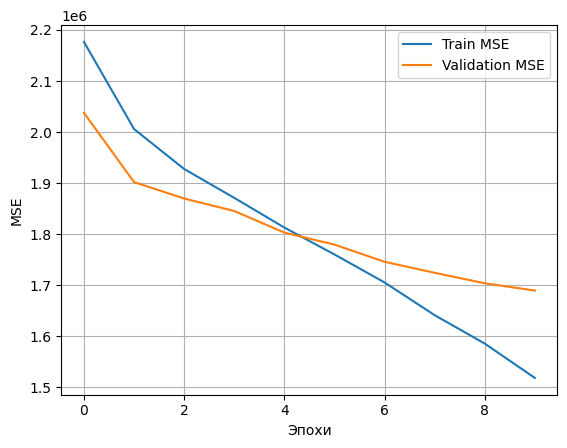

In [73]:
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Validation MSE')
plt.xlabel('Эпохи')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()

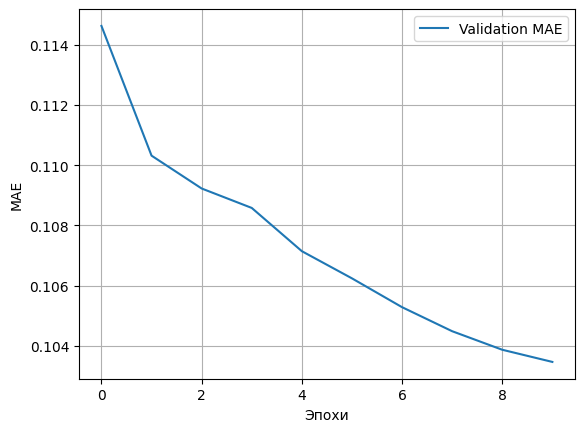

In [74]:
plt.plot(val_maes, label='Validation MAE')
plt.xlabel('Эпохи')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.show()

# CatBoost мультирегрессор на полученных эмбеддингах

In [10]:
emb_model = MultimodalInterviewModel(use_torch_clf=False)
emb_model.load_state_dict(torch.load('model.pt', weights_only=True))
emb_model.to(device)
emb_model.eval()

MultimodalInterviewModel(
  (relu): ReLU()
  (conv1): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (batchnorm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 4, kernel_size=(3,), stride=(1,))
  (batchnorm2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_audio): Linear(in_features=1312, out_features=512, bias=True)
  (fusion_layer): Linear(in_features=2048, out_features=2048, bias=True)
  (output_layer): Linear(in_features=2048, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)

In [46]:
def get_embeddings(dataloader, model, device, has_target=True):
    embeddings_list = []

    if has_target:
        labels_list = []
    
        for batch_idx, (audio_embed, video_embed, text_embed, labels) in enumerate(dataloader):        
            audio_embed, video_embed, text_embed = audio_embed.to(device), video_embed.to(device), text_embed.to(device)
    
            embeds = model(audio_embed, video_embed, text_embed)
    
            embeddings_list.append(embeds.cpu().detach().numpy())
            labels_list.append(labels.cpu().detach().numpy())
            
        return np.concatenate(embeddings_list, axis=0), np.concatenate(labels_list, axis=0)

    else:
        paths_list = []
    
        for batch_idx, (audio_embed, video_embed, text_embed, paths) in enumerate(dataloader):        
            audio_embed, video_embed, text_embed = audio_embed.to(device), video_embed.to(device), text_embed.to(device)
    
            embeds = model(audio_embed, video_embed, text_embed)
    
            embeddings_list.append(embeds.cpu().detach().numpy())
            paths_list += paths
            
        return np.concatenate(embeddings_list, axis=0), paths_list

In [83]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=4)

In [87]:
train_embeds, train_labels = get_embeddings(train_loader, emb_model, device)

val_embeds, val_labels = get_embeddings(val_loader, emb_model, device)

In [88]:
train_embeds.shape, train_labels.shape

((6000, 2048), (6000, 6))

In [89]:
val_embeds.shape, val_labels.shape

((2000, 2048), (2000, 6))

In [92]:
np.save('train_embeds.npy', train_embeds)
np.save('val_embeds.npy', val_embeds)
np.save('train_labels.npy', train_labels)
np.save('val_labels.npy', val_labels)

In [12]:
train_embeds = np.load('train_embeds.npy')
val_embeds = np.load('val_embeds.npy')
train_labels = np.load('train_labels.npy')
val_labels = np.load('val_labels.npy')

In [13]:
train_pool = Pool(data=train_embeds, label=train_labels)
val_pool = Pool(data=val_embeds, label=val_labels)

cb_model = CatBoostRegressor(
    iterations=150,
    learning_rate=0.01,
    depth=12,
    task_type="GPU", 
    loss_function='MultiRMSE',
    boosting_type='Plain',
)

# Обучение модели с валидацией
cb_model.fit(train_pool, eval_set=val_pool, verbose=10)

0:	learn: 0.3646170	test: 0.3553395	best: 0.3553395 (0)	total: 876ms	remaining: 2m 10s
10:	learn: 0.3562591	test: 0.3526100	best: 0.3526100 (10)	total: 9.28s	remaining: 1m 57s
20:	learn: 0.3481993	test: 0.3497751	best: 0.3497751 (20)	total: 17.6s	remaining: 1m 48s
30:	learn: 0.3406058	test: 0.3472821	best: 0.3472821 (30)	total: 26s	remaining: 1m 39s
40:	learn: 0.3329984	test: 0.3448639	best: 0.3448639 (40)	total: 34.4s	remaining: 1m 31s
50:	learn: 0.3258428	test: 0.3427895	best: 0.3427895 (50)	total: 42.8s	remaining: 1m 23s
60:	learn: 0.3189300	test: 0.3408193	best: 0.3408193 (60)	total: 51.1s	remaining: 1m 14s
70:	learn: 0.3123388	test: 0.3390012	best: 0.3390012 (70)	total: 59.4s	remaining: 1m 6s
80:	learn: 0.3057445	test: 0.3371198	best: 0.3371198 (80)	total: 1m 7s	remaining: 57.8s
90:	learn: 0.2996053	test: 0.3355288	best: 0.3355288 (90)	total: 1m 16s	remaining: 49.3s
100:	learn: 0.2934841	test: 0.3340306	best: 0.3340306 (100)	total: 1m 24s	remaining: 41s
110:	learn: 0.2873952	test:

In [14]:
cb_model.save_model('catboost_model.cbm')

In [15]:
y_pred = cb_model.predict(val_embeds)

In [17]:
mae_per_target = [mean_absolute_error(val_labels[:, i], y_pred[:, i]) for i in range(val_labels.shape[1])]
mean_mae = np.mean(mae_per_target)

# Выводим результаты
print("MAE для каждого таргета:", mae_per_target)
print("Средняя MAE по всем таргетам:", mean_mae)

MAE для каждого таргета: [0.10537246375845633, 0.11609811970174087, 0.10974352079179159, 0.09555253710816837, 0.11067153644428135, 0.10697230258714342]
Средняя MAE по всем таргетам: 0.10740174673193033


CatBoost неплохо себя показал, лучшая модель будет выбрана по результатам public score

# Препроцессинг теста

In [18]:
video_folder_test = "./test_dataset/test/test_data/"
pkl_file_test = "./test_dataset/test/transcription/transcription_test.pkl"
labels_test = "./test_dataset/test/annotation/annotation_test.pkl"

test_preprocess_dataset = VideoTextDataset(video_folder_test, pkl_file_test, labels_test, transform=transformer_preprocess, has_target=False)
test_preprocess_loader = DataLoader(test_preprocess_dataset, batch_size=64, shuffle=False, num_workers=4)

In [19]:
#test_embed_dict = preprocess(test_preprocess_loader)

# Convert and write JSON object to file
#with open("test_embed_v2.json", "w") as outfile: 
#    json.dump(test_embed_dict, outfile)

In [28]:
df_test = pd.read_json('test_embed_v2.json')
df_test.head()

,./test_dataset/test/test_data/htH89DBizno.004.mp4,./test_dataset/test/test_data/p_wf-KszNlk.001.mp4,./test_dataset/test/test_data/MuYYY3XaJ7Q.001.mp4,./test_dataset/test/test_data/0MB91ku0eEw.005.mp4,./test_dataset/test/test_data/WpEZOSrENL0.003.mp4,./test_dataset/test/test_data/C2Y9Puk3Obk.004.mp4,./test_dataset/test/test_data/LBKbubsgpE8.000.mp4,./test_dataset/test/test_data/TSGpD2NBeCQ.005.mp4,./test_dataset/test/test_data/54JawR1x0II.004.mp4,./test_dataset/test/test_data/9n8dNi-ERQ0.001.mp4,...,./test_dataset/test/test_data/nLB29nx1Jp4.000.mp4,./test_dataset/test/test_data/YGJ33FXzJO8.001.mp4,./test_dataset/test/test_data/ApPnsnIZozw.000.mp4,./test_dataset/test/test_data/pvvff396Rqg.001.mp4,./test_dataset/test/test_data/nLuAoNAOGcQ.005.mp4,./test_dataset/test/test_data/NzCflfxgvwo.001.mp4,./test_dataset/test/test_data/ch2BcBv4SdQ.003.mp4,./test_dataset/test/test_data/It0-yCwOc5k.001.mp4,./test_dataset/test/test_data/1Wh2mIFrGvk.000.mp4,./test_dataset/test/test_data/a97PXgrKSxo.002.mp4
text_embed,"[0.039306640600000005, -0.0334472656, 0.014343...","[0.072265625, -0.1513671875, 0.095703125, 0.02...","[0.1005859375, -0.11669921870000001, 0.0834960...","[0.037109375, -0.154296875, 0.0888671875, 0.03...","[0.0324707031, -0.087890625, 0.12890625, 0.073...","[0.0071716309, -0.1240234375, 0.072265625, 0.0...","[0.0476074219, -0.1572265625, 0.095703125, 0.0...","[0.0830078125, -0.09423828120000001, 0.1015625...","[0.049072265600000005, -0.1259765625, 0.053466...","[0.068359375, -0.1875, 0.08056640620000001, -0...",...,"[0.08203125, -0.11669921870000001, 0.050048828...","[0.0092163086, -0.1474609375, 0.04443359380000...","[0.1181640625, -0.1484375, 0.052734375, 0.1181...","[0.054199218800000004, -0.17578125, 0.09326171...","[0.0563964844, -0.08837890620000001, 0.0211181...","[0.0668945312, -0.1328125, 0.0688476562, 0.060...","[0.095703125, -0.068359375, 0.0541992188000000...","[0.041259765600000005, -0.0927734375, -0.01904...","[0.11572265620000001, -0.0732421875, 0.0235595...","[0.10009765620000001, -0.0693359375, 0.0810546..."
video_embed,"[-0.0373938009, 0.0030160823, 0.0020373783, -0...","[-0.0192638617, -0.0157252122, 0.0049824743, 0...","[-0.0002313356, 0.0584487766, -0.0044580060000...","[-0.047847408800000005, -0.0049184146000000005...","[0.0002699505, 0.024241453000000003, 0.0625959...","[-0.0805947855, 0.0082945945, -0.0201314110000...","[0.0044889231, -0.0274996851, -0.0163498428, -...","[0.0115573583, -0.07570105790000001, -0.074721...","[-0.0163994562, -0.034537848100000004, -0.0139...","[-0.07459954170000001, 0.022379538, -0.0448950...",...,"[-0.0814897418, 0.0178597402, 0.02773947830000...","[-0.11758688090000001, 0.0454441942, 0.0056313...","[0.0100133112, 0.0357898138, -0.0631165951, -0...","[0.1071261689, -0.0459988527, -0.0002078494, 0...","[-0.0418114066, -0.0066397353000000004, 0.0459...","[0.0438761227, -0.0274401605, 0.00561301830000...","[-0.047027271200000005, 0.045267641500000004, ...","[-0.07467290010000001, -0.016182405900000002, ...","[0.0342120938, 0.0916348323, 0.04380944, -0.02...","[-0.0742718056, 0.06503202770000001, -0.003909..."
audio_embed,"[[-2.9457771778, -2.9498336314999998, -2.69575...","[[-2.3398852348, -2.0455009937, -1.99267375470...","[[-2.2558681965, -2.2787694931, -2.7997500896,...","[[-2.9553146362, -3.2181134224, -3.7200083733,...","[[-3.393124342, -3.6245629787, -4.2735099792, ...","[[-2.6012332439, -2.2694222927, -2.2709701061,...","[[-1.9753205776, -1.9376870394, -2.150826931, ...","[[-2.9950327873, -2.5460956097, -2.5439586639,...","[[-3.1005737782, -2.9576005936, -2.7894518375,...","[[-4.2823991776, -3.6895225048, -3.5280385017,...",...,"[[-2.4501261711, -2.3457458019, -2.8312971592,...","[[-2.8991603851, -2.2719900608, -2.1109769344,...","[[-3.4464669228, -3.0363559723, -2.9384002686,...","[[-3.5910274982, -2.9842679501, -2.758929491, ...","[[-2.5799558163, -2.2948253155, -2.57598805429...","[[-4.8005018234, -4.5435347557, -4.5294895172,...","[[-2.5240383148000003, -1.807032823

# Получение сабмита

In [61]:
torch_model = MultimodalInterviewModel()
torch_model.load_state_dict(torch.load('model.pt', weights_only=True))
torch_model.to(device)
torch_model.eval()

MultimodalInterviewModel(
  (relu): ReLU()
  (conv1): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (batchnorm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 4, kernel_size=(3,), stride=(1,))
  (batchnorm2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_audio): Linear(in_features=1312, out_features=512, bias=True)
  (fusion_layer): Linear(in_features=2048, out_features=2048, bias=True)
  (output_layer): Linear(in_features=2048, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)

In [62]:
test_dataset = PreprocessedDataset(df_test, has_target=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

In [63]:
def get_submit_torch(dataloader, model, device, sample_submit):
    submit = sample_submit.copy()

    for batch_idx, (audio_embed, video_embed, text_embed, file_paths) in enumerate(dataloader):        
        audio_embed, video_embed, text_embed = audio_embed.to(device), video_embed.to(device), text_embed.to(device)

        prediction = model(audio_embed, video_embed, text_embed)

        for i, file_path in enumerate(file_paths):
            for j, ocean in enumerate(submit.keys()):
                submit[ocean][file_path.split('/')[-1]] = prediction[i][j].item()

        
    return submit

In [ ]:
with open('test_submit.pkl', 'rb') as file:
    sample_submit = pickle.load(file, encoding='latin1')
    
submit_torch = get_submit_torch(test_loader, torch_model, device, sample_submit)
# submit_torch

In [65]:
type(submit_torch)

dict

In [66]:
len(submit_torch['extraversion'].keys()) # проверка корректности

2000

In [ ]:
with open('submit_torch.pkl', 'wb') as f:
    pickle.dump(submit_torch, f)

# Для чтения с кодировкой latin1
with open('submit_torch.pkl', 'rb') as f:
    loaded_data = pickle.load(f, encoding='latin1')

# Проверка данных
# print(loaded_data)

In [68]:
torch_model.to('cpu')

emb_model = MultimodalInterviewModel(use_torch_clf=False)
emb_model.load_state_dict(torch.load('model.pt', weights_only=True))
emb_model.to(device)
emb_model.eval()

cb_model = CatBoostRegressor(
    iterations=150,
    learning_rate=0.01,
    depth=12,
    task_type="GPU", 
    loss_function='MultiRMSE',
    boosting_type='Plain',
)

cb_model.load_model('catboost_model.cbm')

In [69]:
test_embeds, paths = get_embeddings(test_loader, emb_model, device, has_target=False)
filenames = [path.split('/')[-1] for path in paths]

In [70]:
def get_submit_cb(cb_model, embeds, filenames, sample_submit):
    submit = sample_submit.copy()

    preds = cb_model.predict(embeds)

    for i, filename in enumerate(filenames):
        for j, ocean in enumerate(submit.keys()):
            submit[ocean][filename] = preds[i][j]

    return submit

In [ ]:
submit_cb = get_submit_cb(cb_model, test_embeds, filenames, sample_submit)
# submit_cb

In [72]:
with open('submit_cb.pkl', 'wb') as f:
    pickle.dump(submit_cb, f)

# Для чтения с кодировкой latin1
with open('submit_cb.pkl', 'rb') as f:
    loaded_data = pickle.load(f, encoding='latin1')

# Проверка данных
print(loaded_data)

{'extraversion': {'htH89DBizno.004.mp4': 0.5687490087366314, 'p_wf-KszNlk.001.mp4': 0.573099304706858, 'MuYYY3XaJ7Q.001.mp4': 0.581041326920058, '0MB91ku0eEw.005.mp4': 0.5461972575335494, 'WpEZOSrENL0.003.mp4': 0.5563599581792005, 'C2Y9Puk3Obk.004.mp4': 0.6101283575844718, 'ask-ZFRztf8.003.mp4': 0.5918478563123699, 'TSGpD2NBeCQ.005.mp4': 0.5180438168654291, '54JawR1x0II.004.mp4': 0.5591930585533191, '9n8dNi-ERQ0.001.mp4': 0.5786378198158673, 'lNG_XdqMf0g.004.mp4': 0.5839025014703711, 'Jy716zClCKs.004.mp4': 0.5849625485556089, 'w_ExyXsnw2A.005.mp4': 0.5918821236537326, 'wKBObhJXCSQ.000.mp4': 0.5503290183187346, 'p6UMx8dwHZQ.005.mp4': 0.517985339286497, 'R42dmIPCXwo.000.mp4': 0.5755915249642385, '3tPq9fNOXZQ.000.mp4': 0.5372413200689152, '-6otZ7M-Mro.002.mp4': 0.5596214976845602, '9UEBU_yiTPs.000.mp4': 0.5688270832988565, 'ouYYWCY__5A.004.mp4': 0.5223167176891366, '69BopbFc34U.002.mp4': 0.4942238214516692, 'SIpQm4G4DDg.003.mp4': 0.5416971320678385, 'u_qvbRpm88k.000.mp4': 0.55588055071325

# Класс для получения преда по одному видео с транскрипцией

In [133]:
class OneVideoProcessor:
    def __init__(self, cb_model=None, emb_model=None, torch_model=None, transformer=None):
        if transformer is None:
            print('Не указан трансформер')
            return

        self.transformer = transformer
        self.cb_model = cb_model
        self.emb_model = emb_model
        self.torch_model = torch_model
        self.ocean = ('openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism', 'interview')

    def transform(self, video_path, transcription):
        text_embed = self.transformer.transform_texts(transcription)
        text_embed = torch.FloatTensor(text_embed)
        frames = self.transformer.get_frames(video_path)
        frames = [torch.FloatTensor(frame) for frame in frames]
        video_embed = self.transformer.transform_video(frames)
        audio_embed = self.transformer.transform_audio(video_path)
        audio_embed = torch.FloatTensor(audio_embed).unsqueeze(0)

        return text_embed, video_embed, audio_embed

    def predict_cb(self, video_path, transcription):
        text_embed, video_embed, audio_embed = self.transform(video_path, transcription)

        audio_embed, video_embed, text_embed = audio_embed.to(device), video_embed.to(device), text_embed.to(device)
        
        embed = self.emb_model(audio_embed, video_embed, text_embed)

        pred = self.cb_model.predict(embed.cpu().detach().numpy())
        pred_dict = dict(zip(self.ocean, pred))

        return pred_dict

    def predict_pt(self, video_path, transcription):
        text_embed, video_embed, audio_embed = self.transform(video_path, transcription)

        audio_embed, video_embed, text_embed = audio_embed.to(device), video_embed.to(device), text_embed.to(device)

        pred = self.torch_model(audio_embed, video_embed, text_embed)

        pred_dict = dict(zip(self.ocean, pred))

        return pred_dict

In [ ]:
cb_model = CatBoostRegressor(
    iterations=150,
    learning_rate=0.01,
    depth=12,
    task_type="GPU", 
    loss_function='MultiRMSE',
    boosting_type='Plain',
)

cb_model.load_model('catboost_model.cbm')

emb_model = MultimodalInterviewModel(use_torch_clf=False)
emb_model.load_state_dict(torch.load('model.pt', weights_only=True))
emb_model.to(device)
emb_model.eval()

torch_model = MultimodalInterviewModel()
torch_model.load_state_dict(torch.load('model.pt', weights_only=True))
torch_model.to(device)
torch_model.eval()

transformer = MultimodalTransformer(device=device)

processor = OneVideoProcessor(cb_model=cb_model, emb_model=emb_model, torch_model=torch_model, transformer=transformer)



# Замер времени

In [95]:
video_folder_train = "./train_dataset/train/train_data/"
pkl_file_train = "./train_dataset/train/transcription/transcription_training.pkl"
labels_train = "./train_dataset/train/annotation/annotation_training.pkl"

one_video_dataset = VideoTextDataset(video_folder_train, pkl_file_train, labels_train, has_target=False)
one_video_loader = DataLoader(one_video_dataset, batch_size=1, shuffle=True)

sample = next(iter(one_video_loader))
sample

{'video_path': ['./train_dataset/train/train_data/7Y4cUPFEt-4.005.mp4'],
 'transcription': ["To do when I'm painting something or maybe I'm going to do a question and answer session or maybe just about an event. So if you download that, then you'll be able to follow me as I do things in real time. Even better than Instagram or Facebook where you have to wait on things you can just get them-"]}

In [140]:
times_cb = []

for i, sample in enumerate(one_video_loader):
    t0 = time()
    cb_pred = processor.predict_cb(sample['video_path'][0], sample['transcription'])
    times_cb.append(time() - t0)
    if i > 30:
        break

print(f"Среднее время обработки видео с помощью CatBoost: {np.mean(times_cb):.2f} с")

Среднее время обработки видео с помощью CatBoost: 0.97 с


In [142]:
times_pt = []

for i, sample in enumerate(one_video_loader):
    t0 = time()
    pt_pred = processor.predict_pt(sample['video_path'][0], sample['transcription'])
    times_pt.append(time() - t0)
    if i > 30:
        break

print(f"Среднее время обработки видео с помощью PyTorch: {np.mean(times_pt):.2f} с")

Среднее время обработки видео с помощью PyTorch: 0.91 с
